# Assignment 7
## Steve Cheney
### RBIF110



## Problem 1

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from collections import Counter


from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

In [26]:
library_file = "Week7-ClusteringData.tsv"
try:
    library = pd.read_csv(library_file, sep="\t", encoding="utf-8")
except UnicodeDecodeError:
    library = pd.read_csv(library_file, sep="\t", encoding="latin-1")

library.head()

,SMILES,ID
0,[NH3+]C1Cc2ccccc2N(Cc2ccc(F)c(C(F)(F)F)c2)C1,RBIF-2163
1,COc1ccccc1N1CCN(CC/C(=N\O)c2ccsc2)CC1,RBIF-1488
2,[NH3+]C1Cc2ccccc2N(Cc2cc(Cl)ccc2Br)C1,RBIF-2899
3,O=C(CCN1CCN(c2ccccc2O)CC1)c1ccc2ccccc2c1,RBIF-4346
4,[NH3+]C1Cc2ccccc2N(Cc2ccc(Cl)cc2Cl)C1,RBIF-0610


In [27]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset
    
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

def calculate_similarity(df, query_smiles):
    """
    Calculate Tanimoto similarity between a query SMILES and a dataframe of molecules

    Args:
        - df: pd.Dataframe, DataFrame containing a 'SMILES' column
        - query_smiles: str, Query molecule in SMILES format

    Returns:
        pd.DataFrame
    """

    df_copy = df.copy()

    # Convert query SMILES to RDKit Mol object
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        raise ValueError("Invalid SMILES string provided for query.")

    # Generate fingerprint for query molecule
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024)

    # Compute similarity scores
    similarity_scores = [
        (DataStructs.TanimotoSimilarity(query_fp, AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
         if mol is not None else None)
        for mol in df_copy['standardized_mol']
    ]

    # Add similarity scores to dataframe
    df_copy['similarity'] = similarity_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return df_sorted

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None

## Question 1

In [28]:
# Clean the data to ignore any NaN smiles values and subset data if needed
library = clean_df_and_create_mol_col(library, 'SMILES', 'mol')
# Get the standardized mol object from the standard SMILES
library['standardized_mol'] = library['SMILES'].apply(get_standard_mol)
# Get the fingerprint
library['fingerprint'] = library['standardized_mol'].apply(get_fingerprint)

descriptor_data = library["standardized_mol"].apply(calculate_descriptors)
descriptor_df = pd.DataFrame(descriptor_data.tolist())

# Merge descriptor data with the original dataset
library = pd.concat([library, descriptor_df], axis=1)

library.head()


,SMILES,ID,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
0,[NH3+]C1Cc2ccccc2N(Cc2ccc(F)c(C(F)(F)F)c2)C1,RBIF-2163,<rdkit.Chem.rdchem.Mol object at 0x000001DD8DD...,<rdkit.Chem.rdchem.Mol object at 0x000001DD91C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",325.329,2,2,3.0177,30.88
1,COc1ccccc1N1CCN(CC/C(=N\O)c2ccsc2)CC1,RBIF-1488,<rdkit.Chem.rdchem.Mol object at 0x000001DD8DD...,<rdkit.Chem.rdchem.Mol object at 0x000001DD91C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",345.468,6,2,3.1473,48.30
2,[NH3+]C1Cc2ccccc2N(Cc2cc(Cl)ccc2Br)C1,RBIF-2899,<rdkit.Chem.rdchem.Mol object at 0x000001DD8DD...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",352.683,2,2,3.2757,30.88
3,O=C(CCN1CCN(c2ccccc2O)CC1)c1ccc2ccccc2c1,RBIF-4346,<rdkit.Chem.rdchem.Mol object at 0x000001DD91C...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",360.457,5,3,3.9404,43.78
4,[NH3+]C1Cc2ccccc2N(Cc2ccc(Cl)cc2Cl)C1,RBIF-0610,<rdkit.Chem.rdchem.Mol object at 0x000001DD91C...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",308.232,2,2,3.1666,30.88


In [29]:
prozac_smiles = "CNCCC(c1ccccc1)Oc2ccc(cc2)C(F)(F)F"
prozac_standard = standardize_smiles(prozac_smiles)
print("Prozac:")
print(prozac_standard)
print(calculate_descriptors(get_standard_mol(prozac_standard)))
sim_scores = calculate_similarity(library, prozac_standard)
sim_scores.head(10)

Prozac:
CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1
{'Molecular_Weight': 309.33099999999996, 'Rotatable_Bonds': 6, 'Aromatic_Bonds': 2, 'ClogP': 4.435000000000003, 'TPSA': 21.259999999999998}


,SMILES,ID,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,similarity
0,CNCC[C@@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-4613,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.4350,21.26,1.000000
1,CNCC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-1003,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.4350,21.26,1.000000
2,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-3762,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.4350,21.26,1.000000
3,[2H]c1c([2H])c(C(F)(F)F)c([2H])c([2H])c1OC(CCN...,RBIF-4534,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",313.355407,6,2,4.4350,21.26,0.761905
4,[2H]c1c([2H])c([2H])c([C@@H](CCNC)Oc2ccc(C(F)(...,RBIF-2753,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",314.361509,6,2,4.4350,21.26,0.697674
5,[2H]c1c([2H])c([2H])c(C(CCNC)Oc2ccc(C(F)(F)F)c...,RBIF-0981,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",314.361509,6,2,4.4350,21.26,0.697674
6,[2H]c1c([2H])c([2H])c([C@H](CCNC)Oc2ccc(C(F)(F...,RBIF-4885,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",314.361509,6,2,4.4350,21.26,0.697674
7,[2H]c1c([2H])c([2H])c(C([2H])(CCNC)Oc2ccc(C(F)...,RBIF-0772,<rdkit.Chem.rdchem.Mol object at 0x000001DD8E9...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",315.367611,6,2,4.4350,21.26,0.541667
8,COc1ccc(N2CCN(CCC(Oc3ccc(C(F)(F)F)cc3)c3ccccc3...,RBIF-1452,<rdkit.Chem.rdchem.Mol object at 0x000001DD8E9...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",470.535000,8,3,6.0464,24.94,0.537037
9,[2H]c1cccc(C([2H])(CCNC)Oc2ccc(C(F)(F)F)c([2H]...,RBIF-2788,<rdkit.Chem.rdchem.Mol object at 0x000001DD8E9...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",314.361509,6,2,4.4350,21.26,0.519231


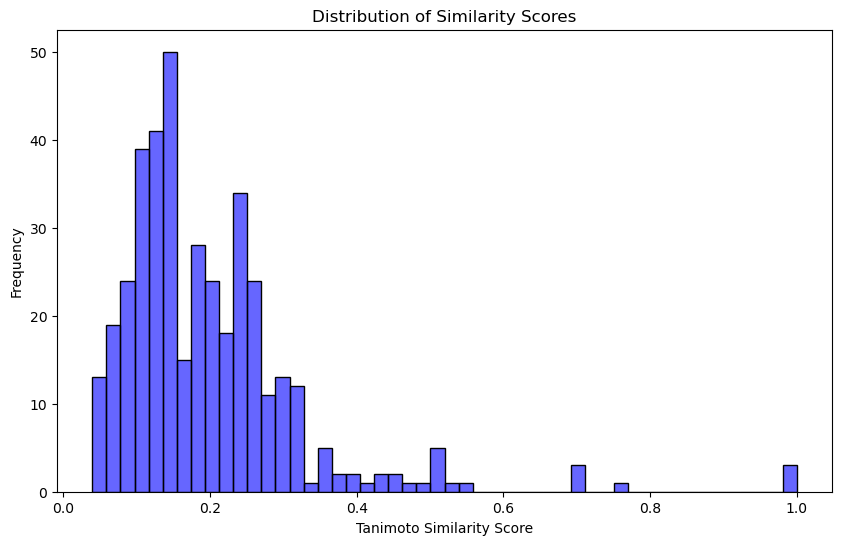

In [30]:
def plot_similarity_distribution(df):
    # Drop NaN values in similarity column
    df_cleaned = df.dropna(subset=['similarity'])

    # Plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(df_cleaned['similarity'], bins=50, color='blue', alpha=0.6)
    
    # Customize plot
    plt.xlabel('Tanimoto Similarity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Similarity Scores')
    
    # Show plot
    plt.show()

plot_similarity_distribution(sim_scores)


It appears that, in addition to Prozac itself being listed in the database (RBIF-3762), RBIF-4613 and RBIF-1003 also appear to be slightly different entries. The next top 3 entries are below:The top three most similar molecules to Prozac based on their Tanimoto similarity scores are:

1. **RBIF-4534 (Similarity: 0.761)**  
   This molecule is structurally very close to Prozac. The molecular weight (313.36 Da) is slightly higher. The **logP (4.435)** and **TPSA (21.26)** are identical to Prozac, indicating similar lipophilicity and polar surface area, suggesting comparable pharmacokinetic behavior.

2. **RBIF-2753 (Similarity: 0.698)**  
   The similarity score is slightly lower due to a **chiral center introduced in the side chain**, potentially affecting receptor interactions. The **molecular weight (314.36 Da)** remains close to Prozac, and with the same **ClogP (4.435) and TPSA (21.26)**, it is likely to have comparable solubility and membrane permeability.

3. **RBIF-0981 (Similarity: 0.698)**  
   Almost identical to RBIF-2753, this molecule differs slightly in **side-chain connectivity**. The **molecular weight, lipophilicity, and polar surface area** remain unchanged (314.36 Da, logP 4.435, TPSA 21.26), suggesting that it might exhibit similar **binding affinity and bioavailability**.

## Question 2

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


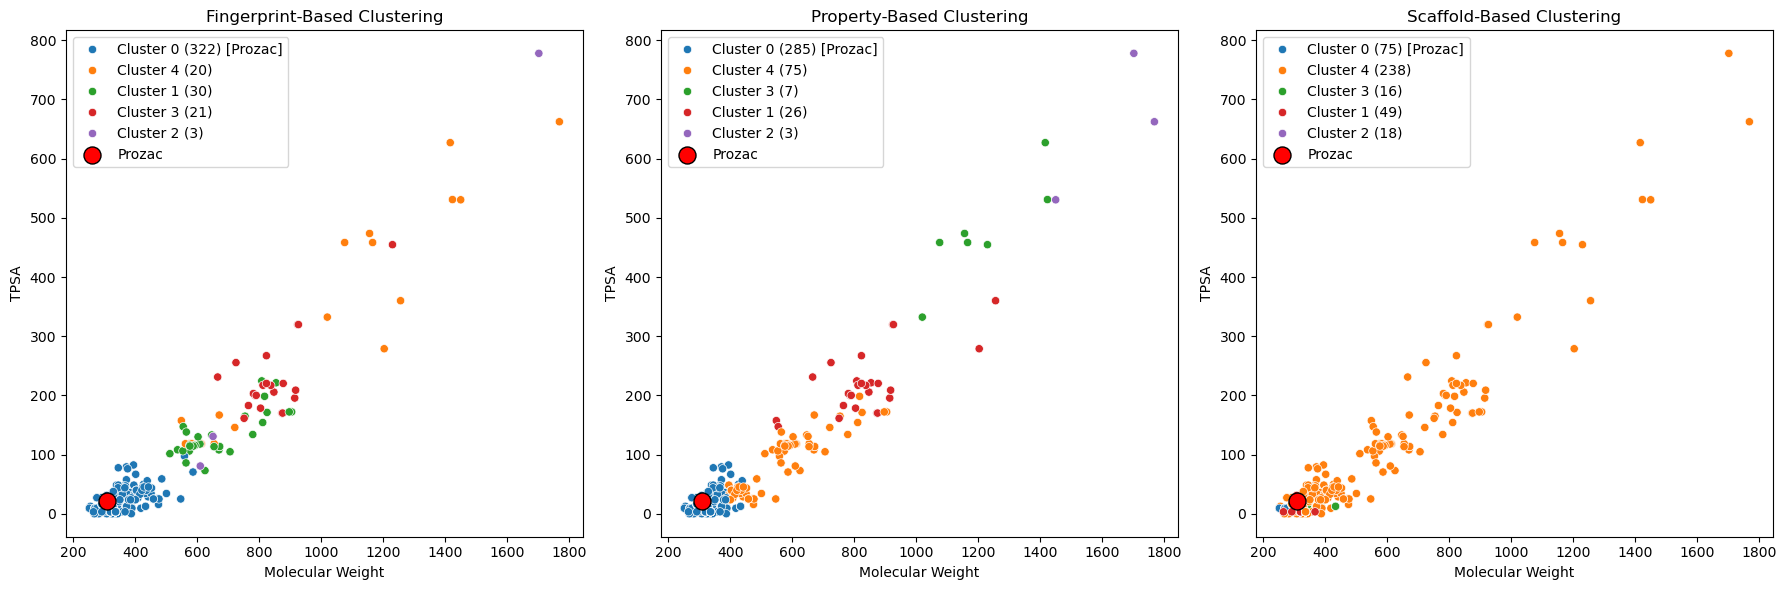

In [46]:
# Prozac's molecular properties
prozac_properties = {
    "Molecular_Weight": 309.33099999999996,
    "Rotatable_Bonds": 6,
    "Aromatic_Bonds": 2,
    "ClogP": 4.435000000000003,
    "TPSA": 21.259999999999998
}

def normalize_property_similarity(df, ref_properties):
    """
    Compute normalized similarity score based on absolute differences from reference values (prozac).
    """
    properties = list(ref_properties.keys())
    df_props = df[properties].copy()

    # Compute absolute differences from Prozac
    for prop in properties:
        df_props[prop] = abs(df_props[prop] - ref_properties[prop])

    # Normalize values between 0 and 1
    scaler = MinMaxScaler()
    normalized_diff = scaler.fit_transform(df_props)

    # Convert to similarity score (1 - normalized difference)
    df["property_similarity"] = 1 - np.mean(normalized_diff, axis=1)
    return df

def cluster_by_fingerprint(df, n_clusters=5):
    """Hierarchical clustering based on Tanimoto similarity."""
    fingerprints = df['fingerprint'].tolist()
    num_mols = len(fingerprints)

    # Compute Tanimoto similarity matrix
    similarity_matrix = np.zeros((num_mols, num_mols))
    for i in range(num_mols):
        for j in range(i, num_mols):
            sim = Chem.DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim
    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance

    # FIX: Use metric instead of affinity
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    df['fingerprint_cluster'] = clustering.fit_predict(distance_matrix)
    return df

def cluster_by_properties(df, n_clusters=5):
    """K-means clustering on normalized molecular properties."""
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
    scaler = MinMaxScaler()
    normalized_props = scaler.fit_transform(df[properties])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['property_cluster'] = kmeans.fit_predict(normalized_props)
    return df

def get_murcko_scaffold(mol):
    """Extract Murcko scaffold."""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol) if mol else None

def cluster_by_scaffold(df, n_scaff=4):
    """Clusters molecules by Murcko scaffold, grouping common scaffolds separately."""
    df['scaffold'] = df['standardized_mol'].apply(get_murcko_scaffold)
    scaffold_counts = Counter(df['scaffold'].dropna())
    top_scaffolds = [scaffold for scaffold, count in scaffold_counts.most_common(n_scaff)]  # Top n scaffolds

    def assign_scaffold_cluster(scaffold):
        return top_scaffolds.index(scaffold) if scaffold in top_scaffolds else len(top_scaffolds)  # Assign 'other'

    df['scaffold_cluster'] = df['scaffold'].apply(assign_scaffold_cluster)
    return df

def main_clustering_pipeline(df, n_clust=5):
    """Runs all clustering methods, computes similarity scores, and visualizes results."""
    df = normalize_property_similarity(df, prozac_properties)
    df = cluster_by_fingerprint(df, n_clust)
    df = cluster_by_properties(df, n_clust)
    df = cluster_by_scaffold(df, n_clust-1)

    # Plot clustering results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cluster_types = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster']
    titles = ["Fingerprint-Based Clustering", "Property-Based Clustering", "Scaffold-Based Clustering"]

    prozac_entry = df[df['ID'] == 'RBIF-3762']

    for i, cluster_col in enumerate(cluster_types):
        # Count occurrences of each cluster
        cluster_counts = df[cluster_col].value_counts().to_dict()

        # Identify Prozac's cluster
        prozac_cluster = df.loc[df['ID'] == 'RBIF-3762', cluster_col].values[0]
        
        # Rename clusters to include counts and highlight Prozac's cluster
        df[f"{cluster_col}_label"] = df[cluster_col].apply(
            lambda x: f"Cluster {x} ({cluster_counts[x]}) {'[Prozac]' if x == prozac_cluster else ''}"
        )

        # Plot with updated labels
        sns.scatterplot(
            x=df['Molecular_Weight'], 
            y=df['TPSA'], 
            hue=df[f"{cluster_col}_label"], 
            palette="tab10", 
            ax=axes[i]
        )

        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Molecular Weight")
        axes[i].set_ylabel("TPSA")
        # Highlight Prozac
        axes[i].scatter(prozac_entry['Molecular_Weight'], prozac_entry['TPSA'], color='red', edgecolor='black', s=150, label="Prozac")
        axes[i].legend()

    plt.tight_layout()
    plt.show()
    
    return df

clustered_df = main_clustering_pipeline(sim_scores)


In [41]:
clustered_df.head()

,SMILES,ID,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA,similarity,property_similarity,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster
0,CNCC[C@@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-4613,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.435,21.26,1.000000,1.000000,0,0,c1ccc(COc2ccccc2)cc1,0
1,CNCC[C@H](Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-1003,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.435,21.26,1.000000,1.000000,0,0,c1ccc(COc2ccccc2)cc1,0
2,CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1,RBIF-3762,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",309.331000,6,2,4.435,21.26,1.000000,1.000000,0,0,c1ccc(COc2ccccc2)cc1,0
3,[2H]c1c([2H])c(C(F)(F)F)c([2H])c([2H])c1OC(CCN...,RBIF-4534,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",313.355407,6,2,4.435,21.26,0.761905,0.999448,0,0,c1ccc(COc2ccccc2)cc1,0
4,[2H]c1c([2H])c([2H])c([C@@H](CCNC)Oc2ccc(C(F)(...,RBIF-2753,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,<rdkit.Chem.rdchem.Mol object at 0x000001DD92B...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",314.361509,6,2,4.435,21.26,0.697674,0.999310,0,0,c1ccc(COc2ccccc2)cc1,0


The fingerprint-based clustering (left plot) groups molecules according to their Tanimoto similarity, meaning that molecules within the same cluster share a high degree of structural resemblance at the atomic and functional group level. This type of clustering is particularly relevant for identifying compounds with similar mechanisms of action, as structurally similar molecules often interact with the same biological targets. Prozac (highlighted in red) is clustered with closely related molecules, which could include other selective serotonin reuptake inhibitors (SSRIs) or analogs with comparable activity [1].

The property-based clustering (middle plot) categorizes molecules based on physicochemical descriptors found within RDKit such as Molecular Weight, Rotatable Bonds, Aromatic Bonds, ClogP, and TPSA. This method provides insight into how well a compound is likely to permeate biological membranes, bind to proteins, or exhibit bioavailability. Prozac is grouped with compounds that share similar pharmacokinetic and physicochemical properties, suggesting that molecules within the same cluster might have comparable drug-like behavior, even if their chemical structures differ.

The scaffold-based clustering (right plot) highlights the core molecular frameworks of the compounds, identifying common structural backbones. Prozac is located within a distinct scaffold-based cluster, which suggests that other molecules in its group might have similar core pharmacophores and could be explored for lead optimization or drug repurposing efforts. Scaffold-based clustering is widely used to design analogs that retain therapeutic activity while improving selectivity, efficacy, or safety [2].

Fingerprint-based clustering helps in identifying compounds with shared biological targets, property-based clustering aids in predicting pharmacokinetic behavior, and scaffold-based clustering supports structural optimization and drug development strategies. The fact that prozac falls within two of the largest clusters fingerprint and property clustering shows that a lot of this database poses to have very similar features to it, and is a potential indicator that this databse is that of other SSRIs or similar compounds.

1. Sohel AJ, Shutter MC, Patel P, et al. Fluoxetine. [Updated 2024 Feb 28]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2025 Feb 24. Available from: https://www.ncbi.nlm.nih.gov/books/NBK459223/
2. Dinic, J., Efferth, T., Garcia-Sosa, A. T., Grahovac, J., Padron, J. M., Pajeva, I., Rizzolio, F., Saponara, S., Spengler, G., & Tsakovska, I. (2020). Repurposing old drugs to fight multidrug resistant cancers. Drug Resist Updat, 52, 100713. https://doi.org/10.1016/j.drup.2020.100713 


## Question 3

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


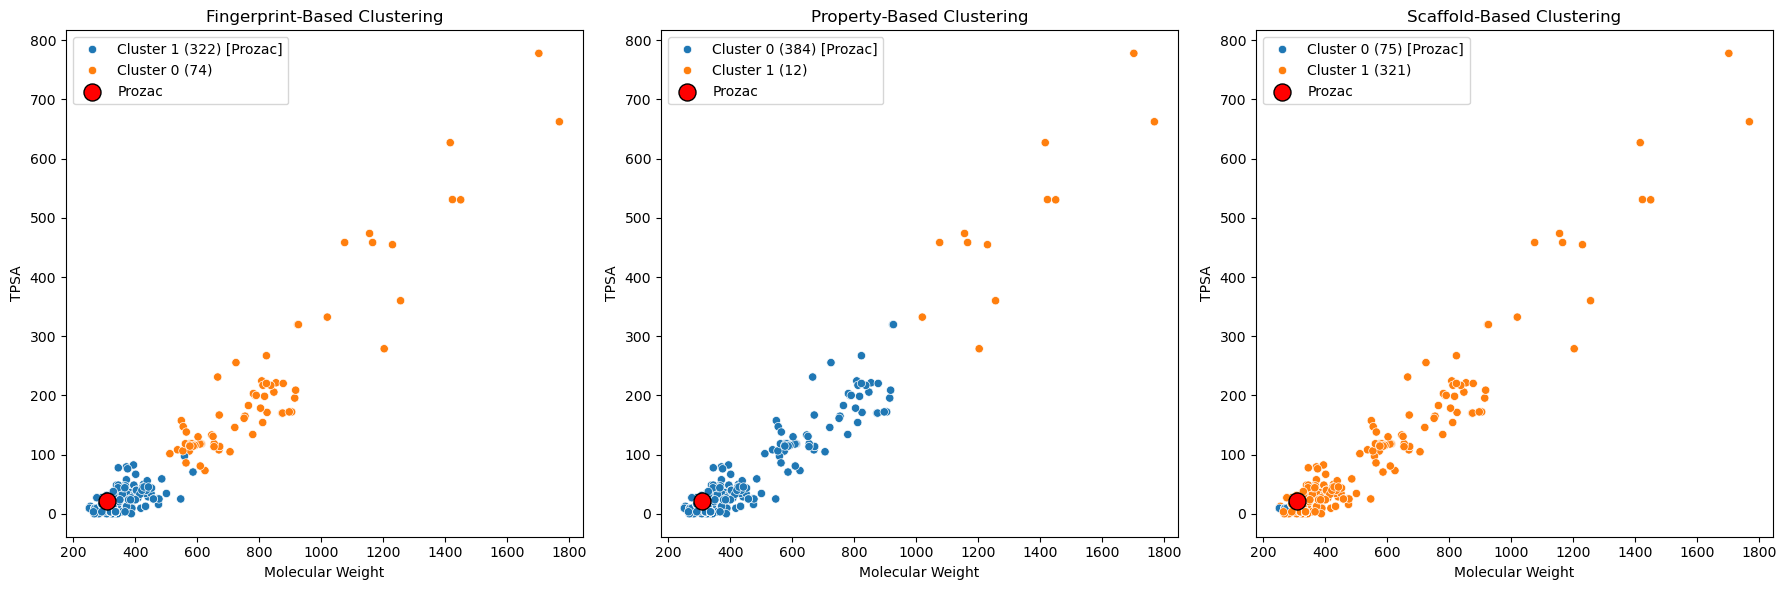

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


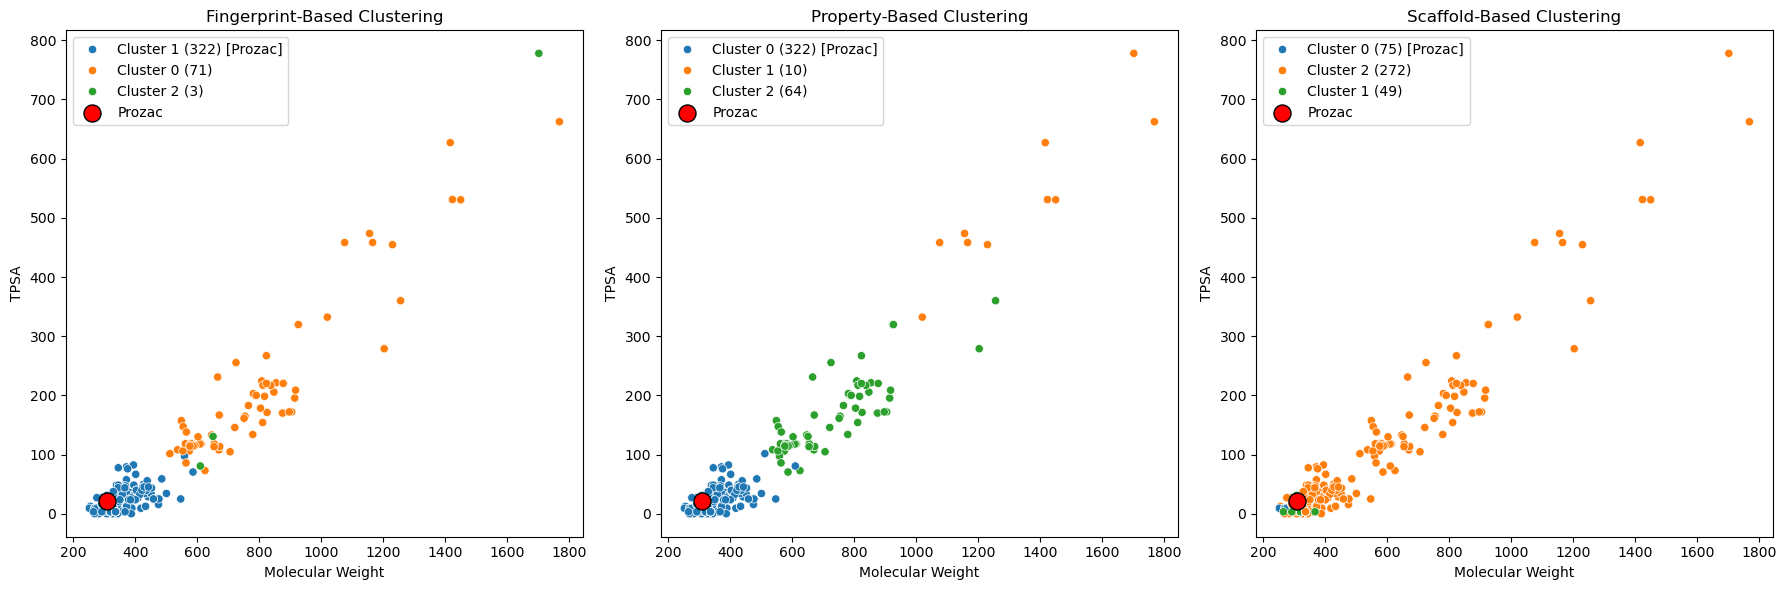

s:\Coding\miniconda3\envs\pymol_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


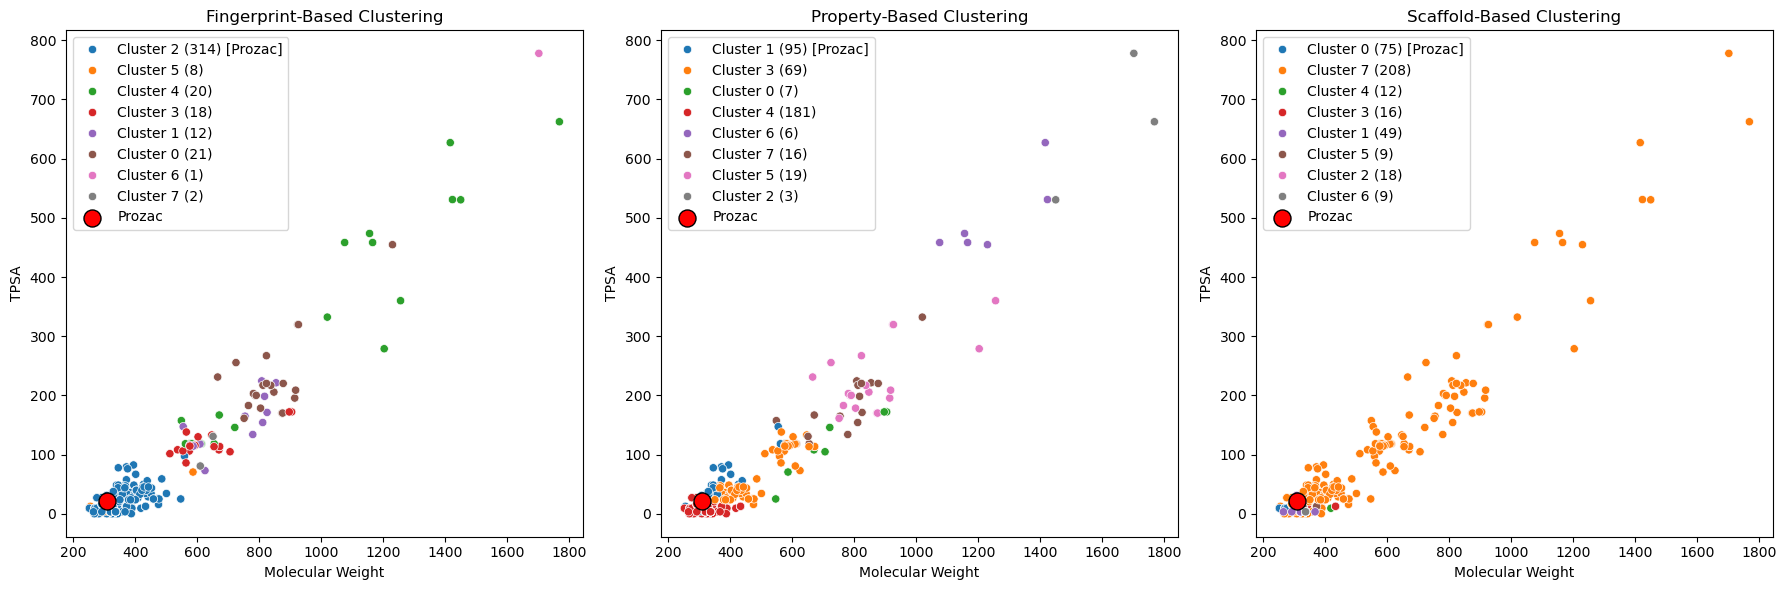

In [47]:
n_2_df = main_clustering_pipeline(sim_scores, 2)
n_3_df = main_clustering_pipeline(sim_scores, 3)
n_8_df = main_clustering_pipeline(sim_scores, 8)



We can see that when decreasing the cluster count (n=2 & n=3), prozac is still located in the largest cluster count, same as the original n=5. However, for the scaffold, it's routinely within the second largest cluster. I would posit that this is because the majority of the molecules in the library have a different scaffold differentiating their structure as being different that prozac, therefore it's not going to be labeled within that scaffold cluster. To demonstrate this here's a comparison of prozac's scaffold and another in this separate cluster:

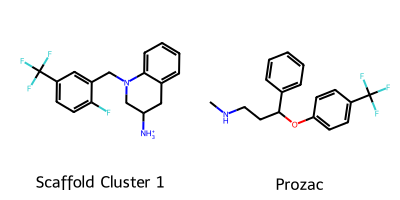

In [49]:
scaffold_cluster_1_mol = n_2_df[n_2_df['scaffold_cluster'] == 1].iloc[0]['standardized_mol']
prozac_mol = n_2_df[n_2_df['ID'] == 'RBIF-3762'].iloc[0]['standardized_mol']

Draw.MolsToGridImage([scaffold_cluster_1_mol, prozac_mol], molsPerRow=2, legends=["Scaffold Cluster 1", "Prozac"])


We can see that there is a biphenyl in the scaffold 1 cluster versus prozac not having any, even though both have two separate benzenes in the full structure. This is most likely the reason for the differing clusters no matter the cluster count.